In [2]:
from diffusers import DiffusionPipeline

repo_id = "CompVis/ldm-text2im-large-256"
ldm = DiffusionPipeline.from_pretrained(repo_id)

Fetching 11 files:   0%|          | 0/11 [00:00<?, ?it/s]

The config attributes {'timestep_values': None} were passed to DDIMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [25]:
image = ldm("FanTaBlUe")

  0%|          | 0/50 [00:00<?, ?it/s]

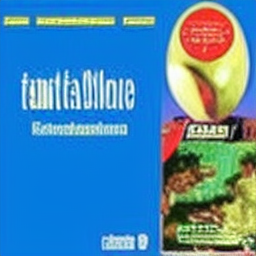

In [26]:
image.images[0]

TypeError: Image data of dtype object cannot be converted to float

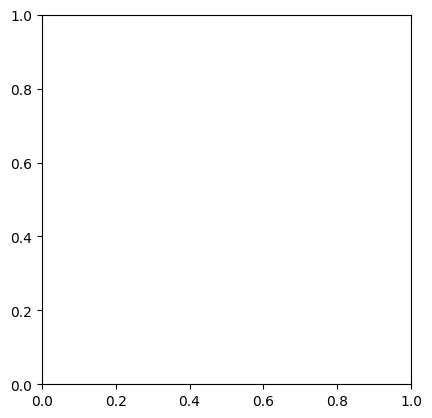

In [5]:
import matplotlib.pyplot as plt

plt.imshow(image)